# Nereus - Comprehensive Demonstration

This notebook demonstrates all the main features of the `nereus` package for working with unstructured ocean model data.

## Features covered:
- 2D map plotting with various projections
- Regridding unstructured data to regular grids
- Interpolator caching for performance
- Polar projections
- Vertical transects
- Working with 3D data (depth levels)
- Working with element-based data

## Setup and Data Loading

In [2]:
import nereus as nr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

print(f"Nereus version: {nr.__version__}")

Nereus version: 0.2.0


Tutorial data can be found at:
- levante: `/work/ab0995/a270088/nereus_tutorial_data`
- downloaded from here (12.5 Gb): `https://swift.dkrz.de/v1/dkrz_035d8f6ff058403bb42f8302e6badfbc/nereus_tutorial_data/nereus_tutorial_data.tar`

In [121]:
# Load FESOM2 mesh and data
mesh = xr.open_dataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/fesom.mesh.diag.nc')
temp = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/temp.fesom.196*.nc')
data_u = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/u.fesom.196*.nc')  # data on elements

print(f"Mesh nodes: {len(mesh.lon)}")
print(f"Mesh elements: {len(mesh.elem_area)}")
print(f"Temperature shape: {data.temp.shape}")
print(f"U velocity shape: {data_u.u.shape}")

Mesh nodes: 126858
Mesh elements: 244659
Temperature shape: (120, 47, 126858)
U velocity shape: (120, 47, 244659)


In [8]:
# Extract coordinates from mesh
lon = mesh.lon.values
lat = mesh.lat.values
print(f"Node coordinates: lon {lon.shape}, lat {lat.shape}")

Node coordinates: lon (126858,), lat (126858,)


## 1. Basic 2D Map Plotting

The `nr.plot()` function handles regridding and plotting in one step.

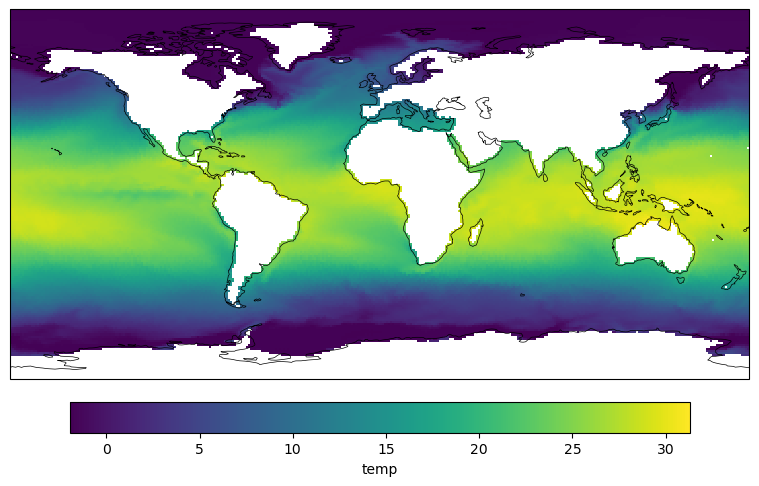

In [9]:
#simplest plot
nr.plot(temp['temp'][0,0,:], lon, lat);

In [11]:
import cmocean as cmo

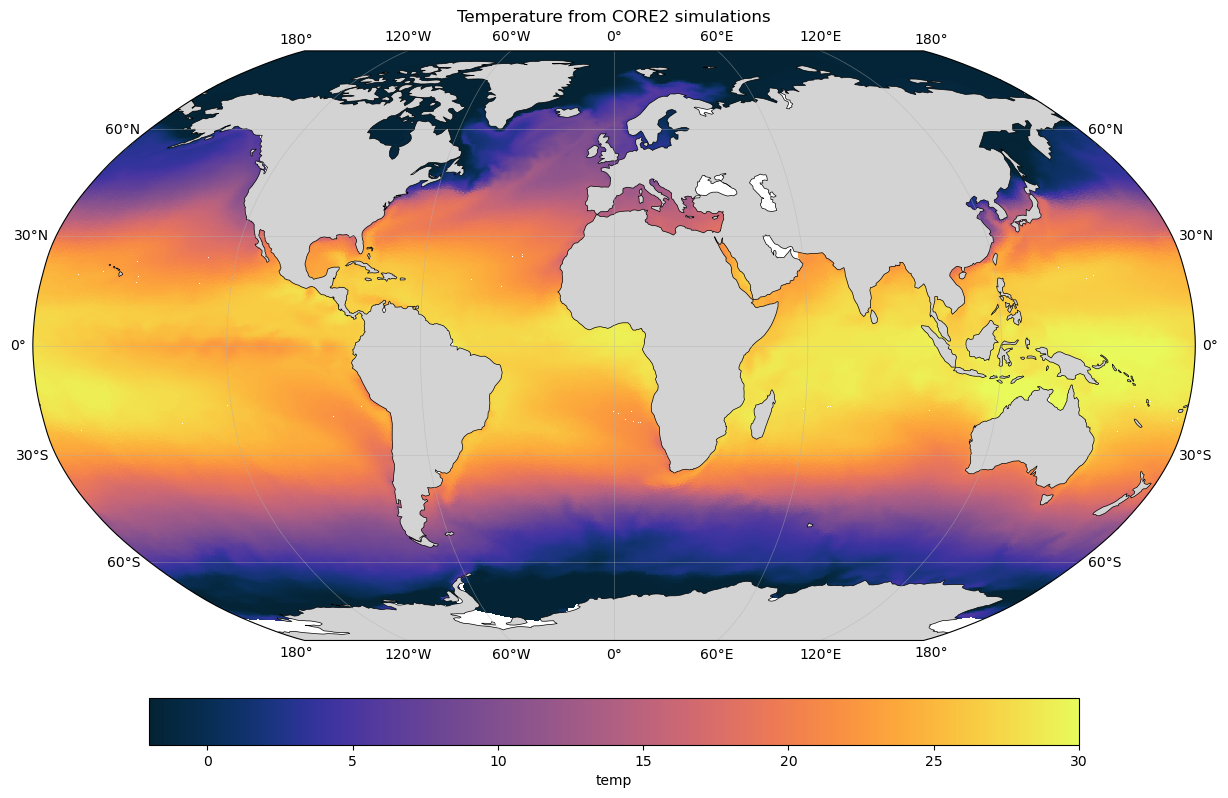

In [12]:
# More advanced plotting
nr.plot(temp['temp'][0,0,:],
        lon,
        lat, 
        projection='rob',
        resolution=0.25, 
        influence_radius=80000,
        land=True,
        cmap=cmo.cm.thermal, 
        vmin=-2, 
        vmax=30,
        coastlines=True, 
        gridlines=True, 
        title="Temperature from CORE2 simulations",
        figsize=(15,15), 
       );

## 2. Reusing the Interpolator

The interpolator returned by `nr.plot()` can be reused for other variables on the same mesh, which is much faster.

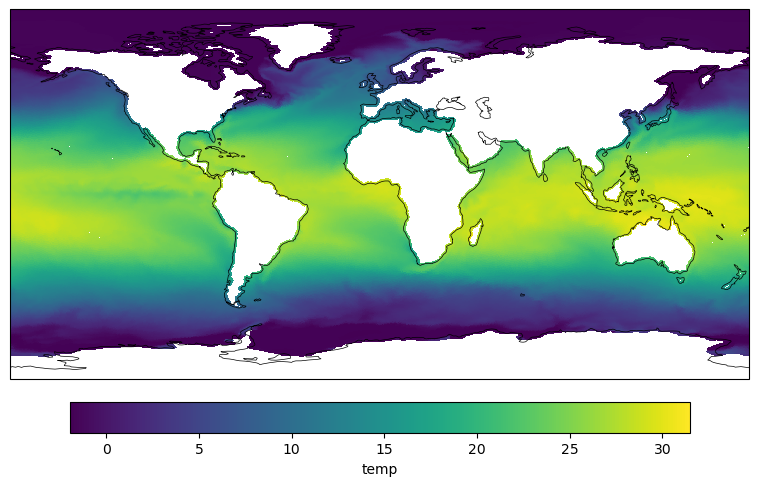

In [19]:
_, _, interp = nr.plot(temp['temp'][0,0,:], lon, lat, resolution=0.25)

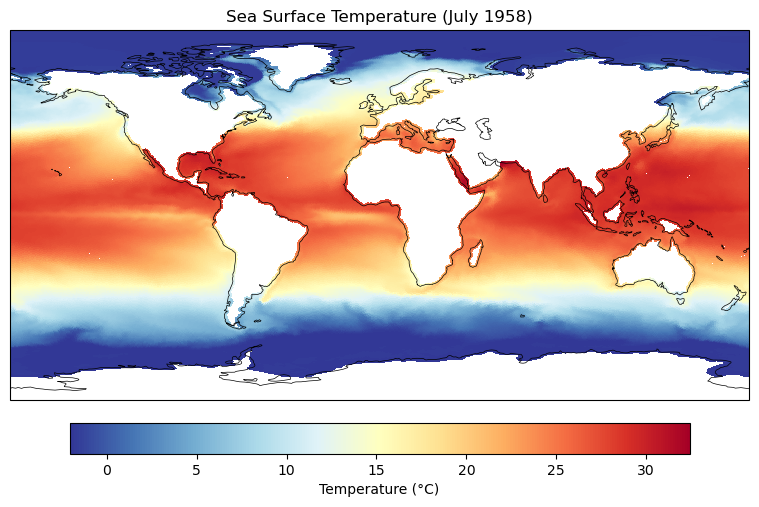

In [20]:
# Plot temperature at a different time using the same interpolator
sst_july = temp.temp.isel(time=6, nz1=0).values

fig, ax, _ = nr.plot(
    sst_july, lon, lat,
    interpolator=interp,  # Reuse the interpolator
    title="Sea Surface Temperature (July 1958)",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r"
)

## 3. Different Map Projections

Nereus supports multiple projections:
- `pc` - PlateCarree (default)
- `rob` - Robinson
- `merc` - Mercator
- `moll` - Mollweide
- `np` - North Polar Stereographic
- `sp` - South Polar Stereographic
- `ortho` - Orthographic
- `lcc` - Lambert Conformal

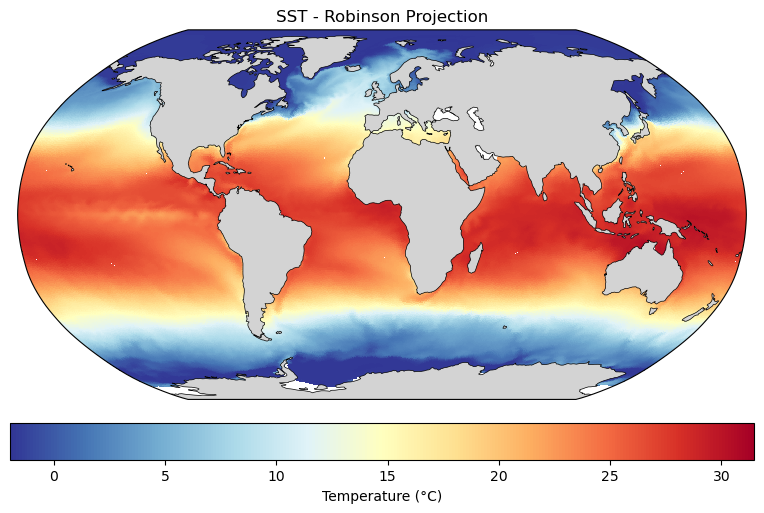

In [23]:
# Robinson projection (good for global maps)
fig, ax, _ = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    projection="rob",
    title="SST - Robinson Projection",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    resolution=0.25,
    land=True
)

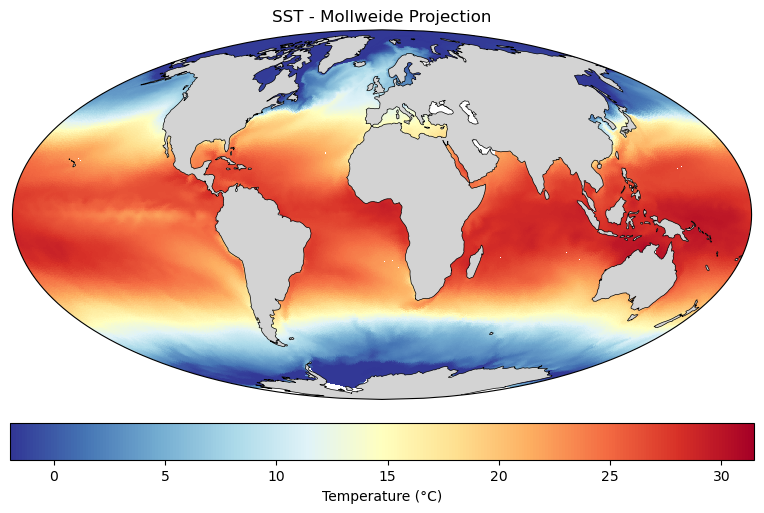

In [26]:
# Mollweide projection
fig, ax, _ = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    projection="moll",
    title="SST - Mollweide Projection",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    resolution=0.25,
    land=True
)

## 4. Polar Projections

Use `np` for North Polar and `sp` for South Polar stereographic projections.

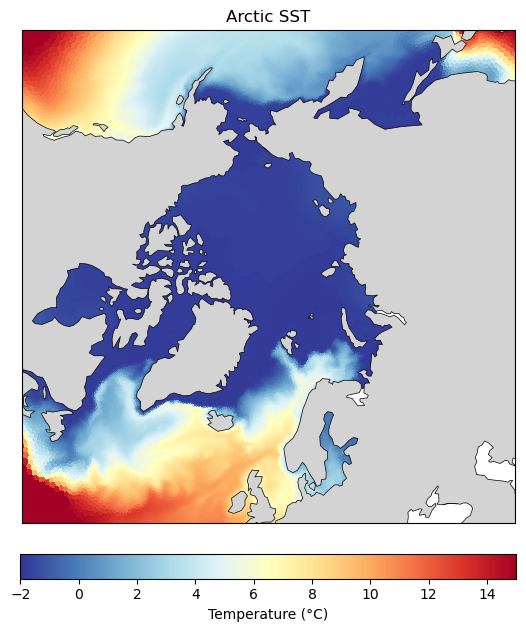

In [30]:
# North Polar Stereographic
fig, ax, interp_np = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    projection="np",
    extent=(-180, 180, 50, 90),
    title="Arctic SST",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    vmin=-2, vmax=15,
    resolution = 0.1,
    land=True
)

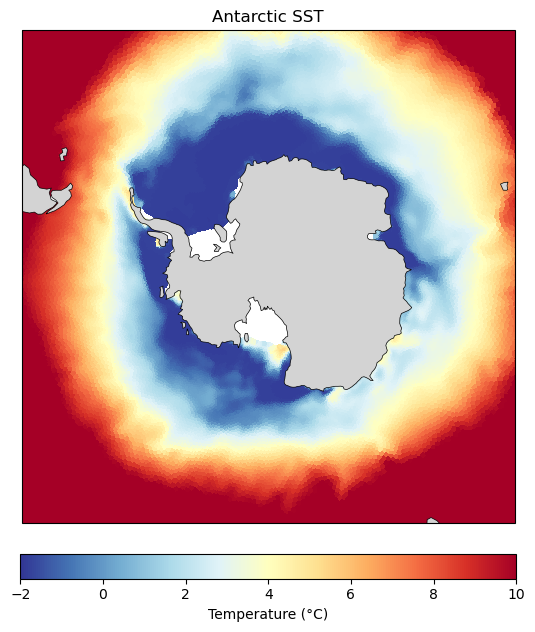

In [31]:
# South Polar Stereographic
fig, ax, interp_sp = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    projection="sp",
    extent=(-180, 180, -90, -50),
    title="Antarctic SST",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    vmin=-2, vmax=10,
    resolution = 0.1,
    land=True
)

## 5. Regional Plots

Use the `extent` parameter to focus on a specific region.

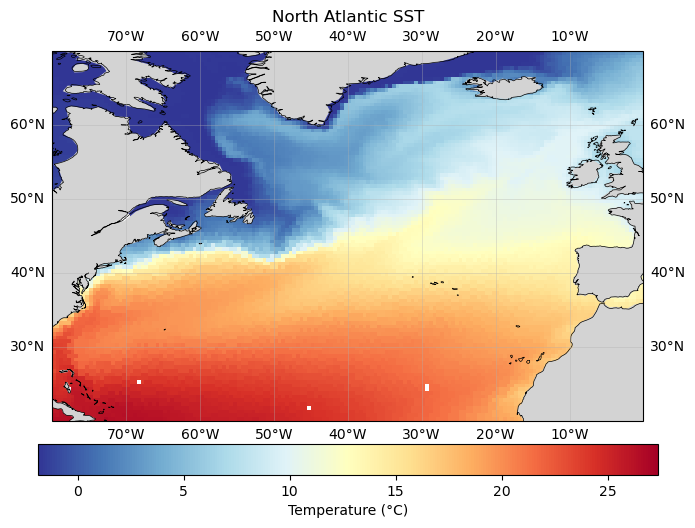

In [33]:
# North Atlantic region
fig, ax, interp_natl = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    extent=(-80, 0, 20, 70),
    resolution=0.5,  # Higher resolution for regional plot
    title="North Atlantic SST",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    land=True,
    gridlines=True
)

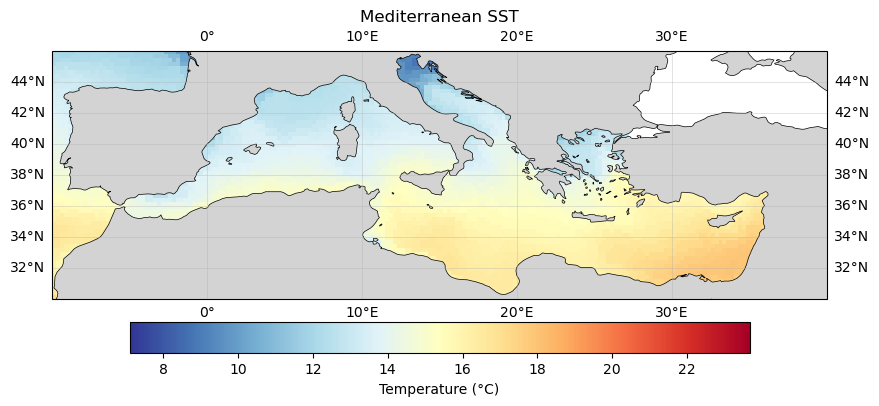

In [34]:
# Mediterranean Sea
fig, ax, _ = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    extent=(-10, 40, 30, 46),
    resolution=0.25,  # Even higher resolution
    title="Mediterranean SST",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    land=True,
    gridlines=True
)

## 6. Working with multipanel plots

The temperature data has 47 depth levels. Let's plot temperature at different depths.

In [35]:
# Show available depth levels
print("Depth levels (m):")
print(temp.nz1.values[:15])  # First 15 levels

Depth levels (m):
[  2.5   7.5  15.   25.   35.   45.   55.   65.   75.   85.   95.  107.5
 125.  147.5 175. ]


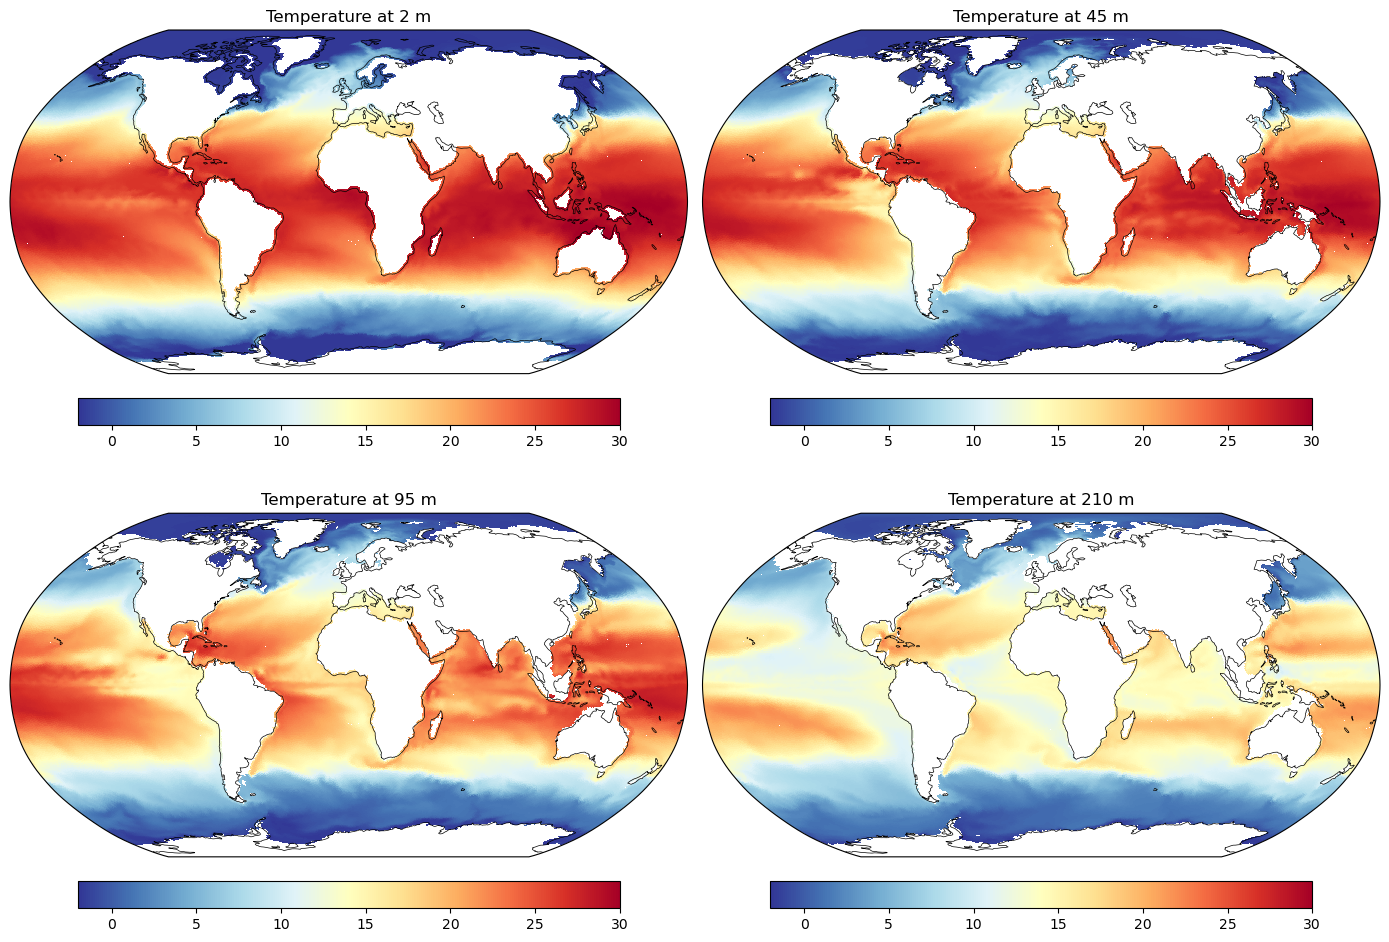

In [36]:
# Plot temperature at multiple depths
depths_idx = [0, 5, 10, 15]  # Surface, ~50m, ~150m, ~400m

fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                         subplot_kw={'projection': nr.plotting.get_projection('rob')})

for idx, ax in zip(depths_idx, axes.flat):
    depth = float(data.nz1.values[idx])
    temp_at_depth = data.temp.isel(time=0, nz1=idx).values
    
    nr.plot(
        temp_at_depth, lon, lat,
        ax=ax,
        interpolator=interp,
        title=f"Temperature at {depth:.0f} m",
        cmap="RdYlBu_r",
        vmin=-2, vmax=30,
        colorbar=True
    )

plt.tight_layout()

In [44]:
# compute monthly climatology
monthly_clim = temp['temp'][:,0,:].groupby("time.month").mean("time").compute()

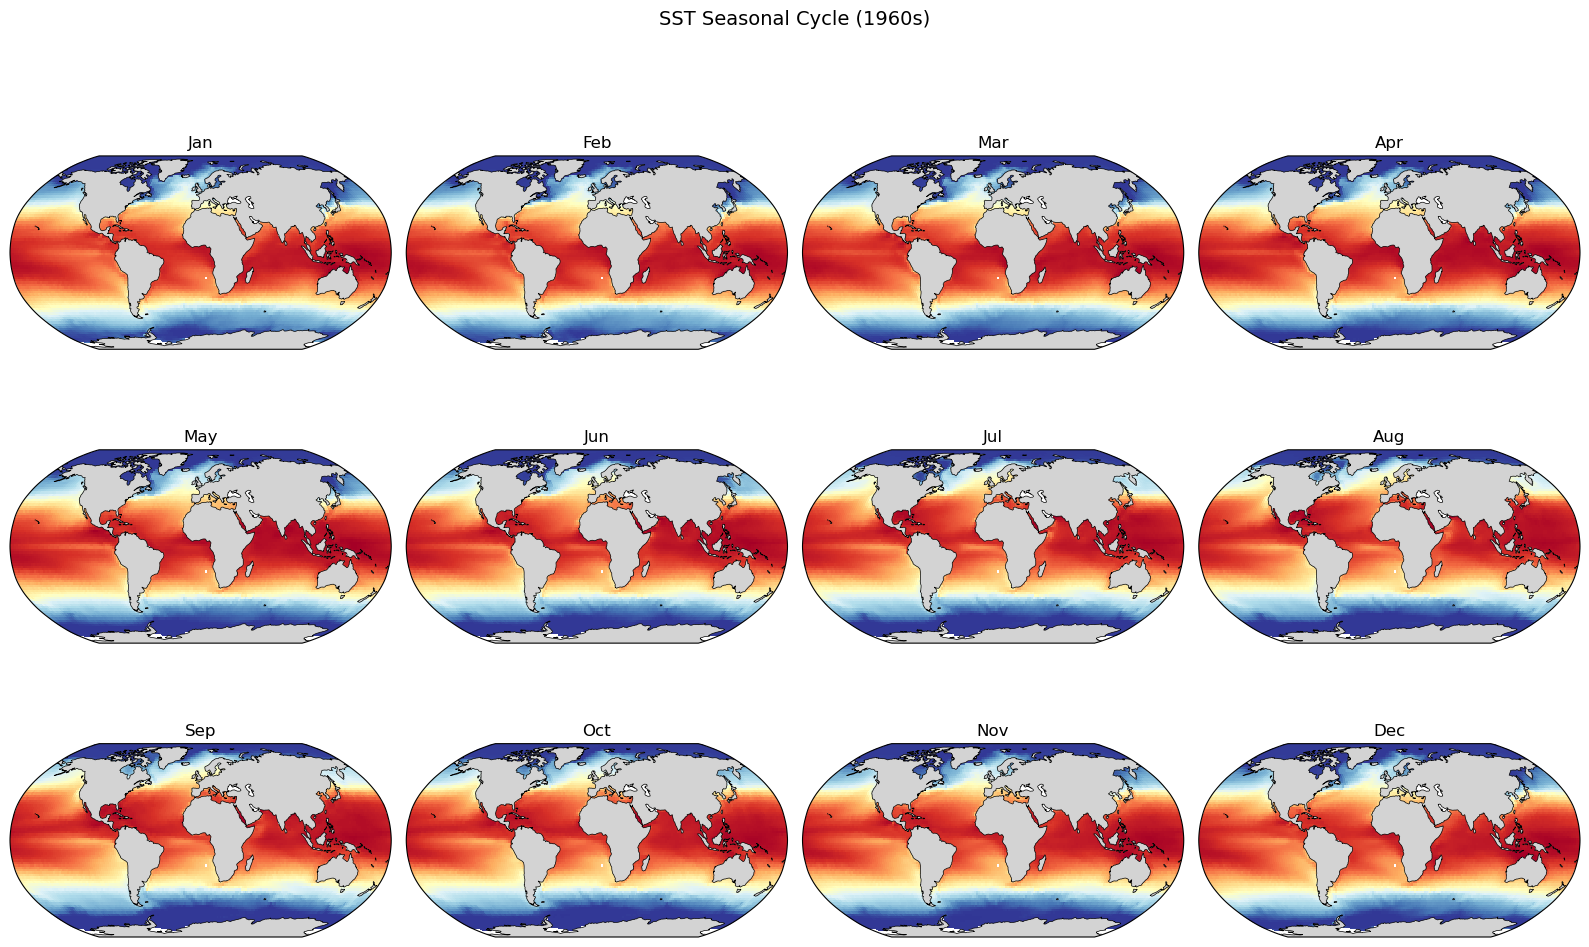

In [48]:
# Plot seasonal cycle
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Not necesary, but will be faster
interpolator = nr.RegridInterpolator(
    lon, lat,
    resolution=2.0,
    # influence_radius=80_000  # default, can increase for coarse meshes
)

fig, axes = plt.subplots(3, 4, figsize=(16, 10),
                         subplot_kw={'projection': nr.plotting.get_projection('rob')})

for i, (ax, month) in enumerate(zip(axes.flat, months)):
    nr.plot(
        monthly_clim[i,:], lon, lat,
        ax=ax,
        interpolator=interpolator,
        title=month,
        cmap="RdYlBu_r",
        vmin=-2, vmax=30,
        colorbar=False,
        land=True
    )

plt.suptitle("SST Seasonal Cycle (1960s)", fontsize=14, y=1.02)
plt.tight_layout()

In [49]:
# Compute seasonal climatology
seasonal_clim = temp['temp'][:,0,:].groupby("time.season").mean("time").compute()

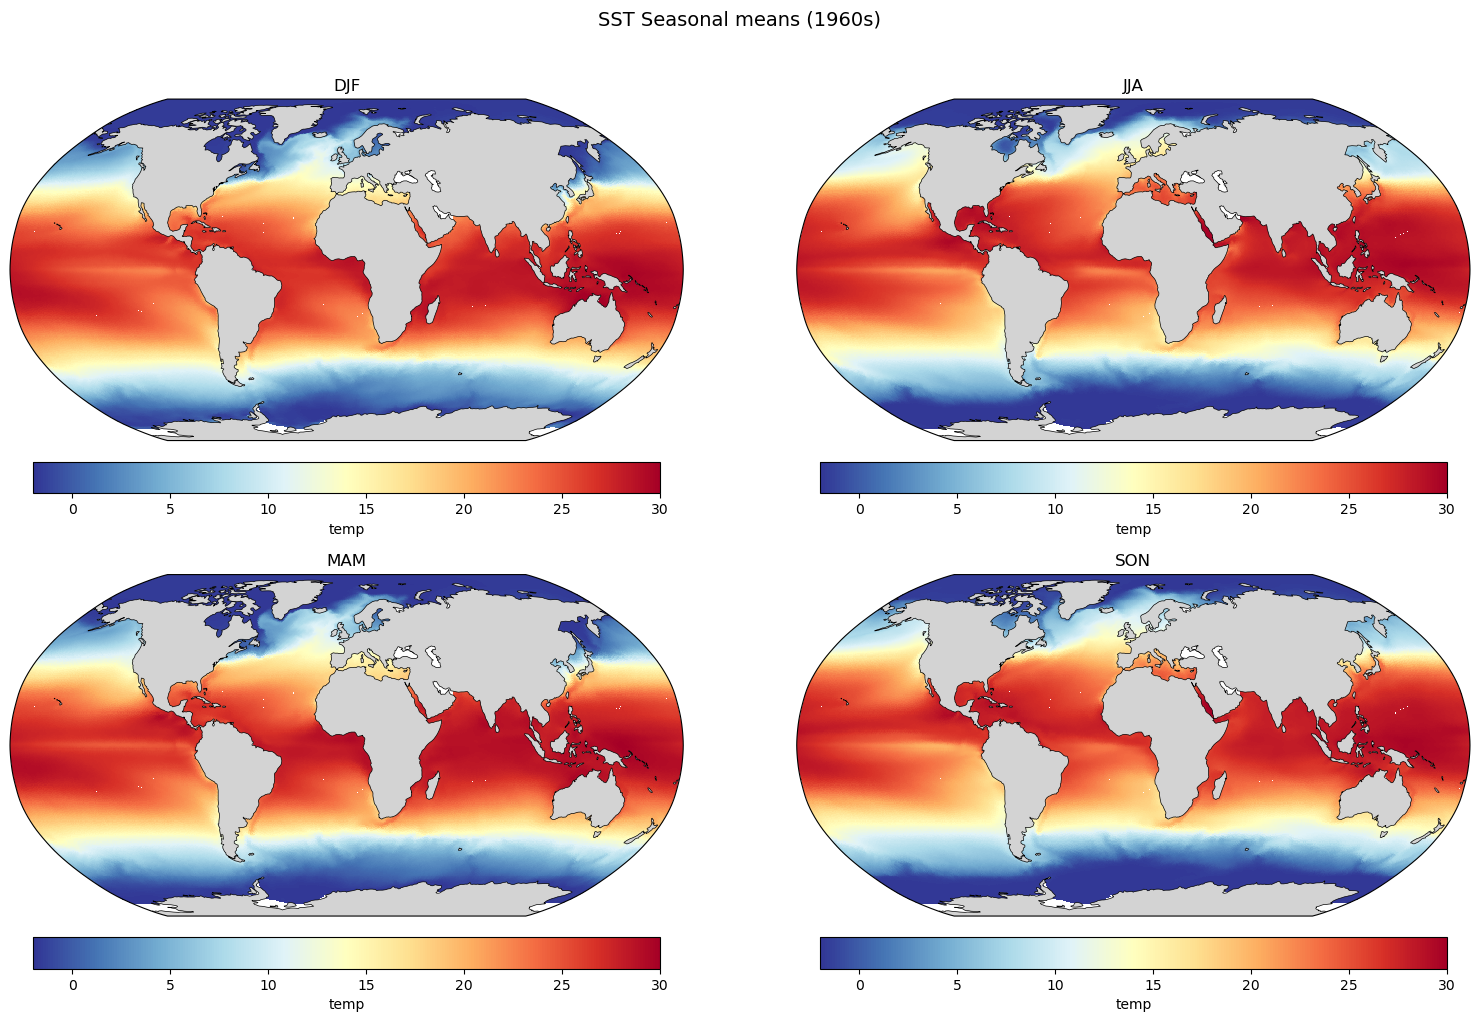

In [51]:
# Plot seasonal means
seasons = ['DJF', 'JJA', 'MAM', 'SON']
# Not necesary, but will be faster
interpolator = nr.RegridInterpolator(
    lon, lat,
    resolution=0.5,
    # influence_radius=80_000  # default, can increase for coarse meshes
)

fig, axes = plt.subplots(2, 2, figsize=(16, 10),
                         subplot_kw={'projection': nr.plotting.get_projection('rob')})

for i, (ax, season) in enumerate(zip(axes.flat, seasons)):
    nr.plot(
        seasonal_clim[i,:], lon, lat,
        ax=ax,
        interpolator=interpolator,
        title=season,
        cmap="RdYlBu_r",
        vmin=-2, vmax=30,
        colorbar=True,
        land=True
    )

plt.suptitle("SST Seasonal means (1960s)", fontsize=14, y=1.02)
plt.tight_layout()

## 2. Direct Regridding (without plotting)

Use `nr.regrid()` to regrid data without plotting, useful for further analysis.

In [65]:
# Regrid SST to a 1-degree regular grid
sst_regridded, regrid_interp = nr.regrid(
    temp['temp'][0,0,:], lon, lat,
    resolution=1.0
)

print(f"Original shape: {temp['temp'][0,0,:].shape}")
print(f"Regridded shape: {sst_regridded.shape}")
print(f"Target lon range: {regrid_interp.target_lon.min():.1f} to {regrid_interp.target_lon.max():.1f}")
print(f"Target lat range: {regrid_interp.target_lat.min():.1f} to {regrid_interp.target_lat.max():.1f}")

Original shape: (126858,)
Regridded shape: (180, 360)
Target lon range: -179.5 to 179.5
Target lat range: -89.5 to 89.5


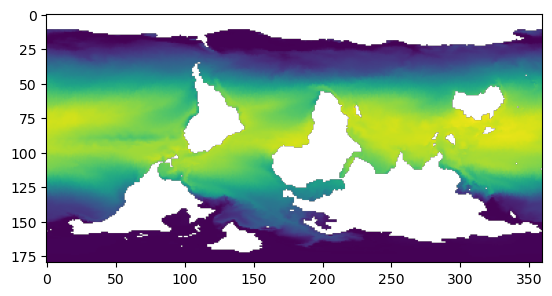

In [55]:
plt.imshow(sst_regridded)

In [95]:
%%time
# regrid all time steps and all levels
# there is faster way with reusing interpolator, see below 
all_temp_regridded, regrid_interp = nr.regrid(
    temp['temp'], lon, lat,
    resolution=1.0
)

CPU times: user 17.5 s, sys: 1.31 s, total: 18.8 s
Wall time: 17.2 s


In [69]:
all_temp_regridded.shape

(120, 47, 180, 360)

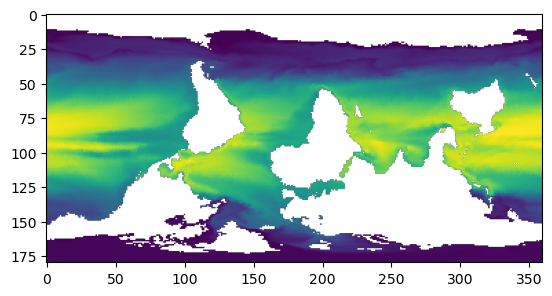

In [61]:
plt.imshow(all_temp_regridded[20,10,:])

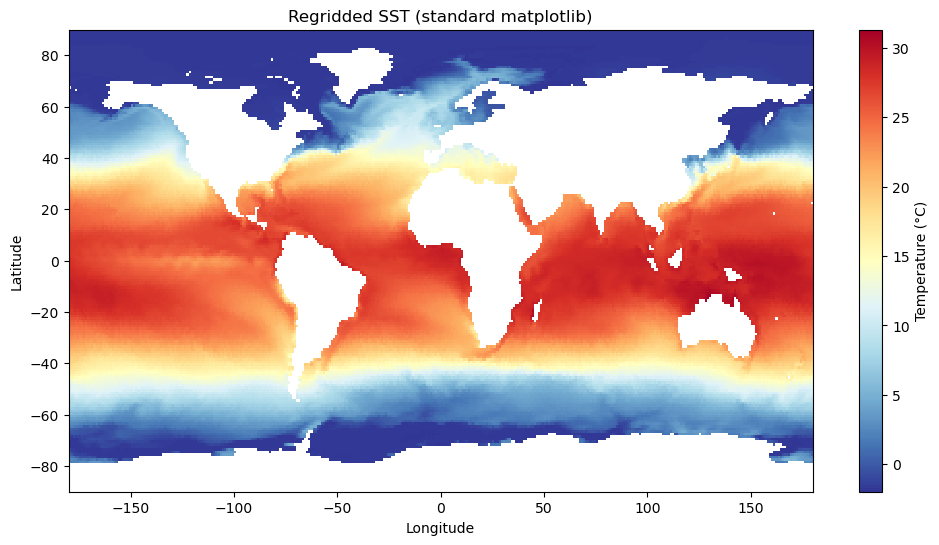

In [66]:
# Plot the regridded data using standard matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.pcolormesh(
    regrid_interp.target_lon,
    regrid_interp.target_lat,
    sst_regridded,
    cmap="RdYlBu_r"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Regridded SST (standard matplotlib)")
plt.colorbar(im, label="Temperature (°C)")

In [86]:
# Regrid to a specific region with higher resolution
sst_natl, interp_natl_regrid = nr.regrid(
    temp['temp'][0,0,:], lon, lat,
    resolution=0.1,
    lon_bounds=(-80, 0),
    lat_bounds=(20, 70),
    # influence_radius=75000
)

print(f"North Atlantic regridded shape: {sst_natl.shape}")

North Atlantic regridded shape: (500, 800)


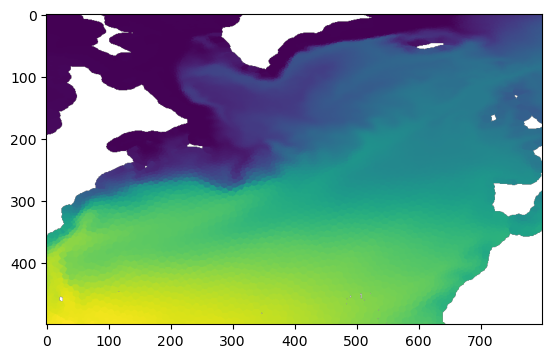

In [87]:
plt.imshow(np.flipud(sst_natl))

## 8. Using RegridInterpolator Directly

For more control, create a `RegridInterpolator` directly.

In [92]:
# Create interpolator for the full time series
# Default influence_radius is 80 km, suitable for most meshes
# For coarser meshes like pi-mesh, you may need larger values (e.g., 500 km)
interpolator = nr.RegridInterpolator(
    lon, lat,
    resolution=1.0,
    # influence_radius=80_000  # default, can increase for coarse meshes
)

print(f"Interpolator target shape: {interpolator.shape}")
print(f"Valid points: {interpolator.valid_mask.sum()} / {interpolator.valid_mask.size}")

Interpolator target shape: (180, 360)
Valid points: 45899 / 64800


In [93]:
%%time
# Regrid all time steps at once

all_times = temp.temp.values 
print(f"Input shape: {all_times.shape}")

regridded_all = interpolator(all_times)
print(f"Output shape: {regridded_all.shape}")

Input shape: (120, 47, 126858)
Output shape: (120, 47, 180, 360)
CPU times: user 8.97 s, sys: 737 ms, total: 9.7 s
Wall time: 8.91 s


## 9. Working with Element-Based Data

Some variables (like velocity) are defined on mesh elements rather than nodes. We use element center coordinates for these.

In [122]:
from nereus.core import compute_element_centers
lon_elem, lat_elem = compute_element_centers(lon, lat, mesh.face_nodes.values-1)

data_u = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/u.fesom.196*.nc')

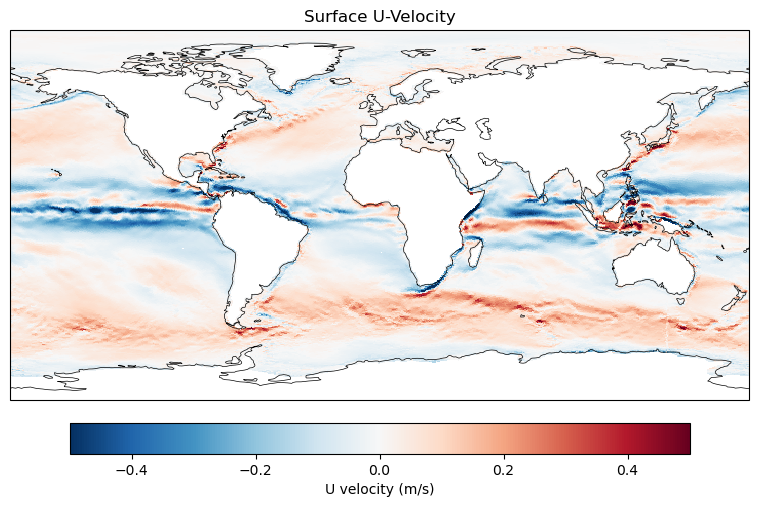

In [98]:
# Plot surface u-velocity (on elements)

u_surface = data_u.u.isel(time=0, nz1=0).values

fig, ax, interp_elem = nr.plot(
    u_surface, lon_elem, lat_elem,
    title="Surface U-Velocity",
    colorbar_label="U velocity (m/s)",
    cmap="RdBu_r",
    vmin=-0.5, vmax=0.5, 
    resolution=0.5
)

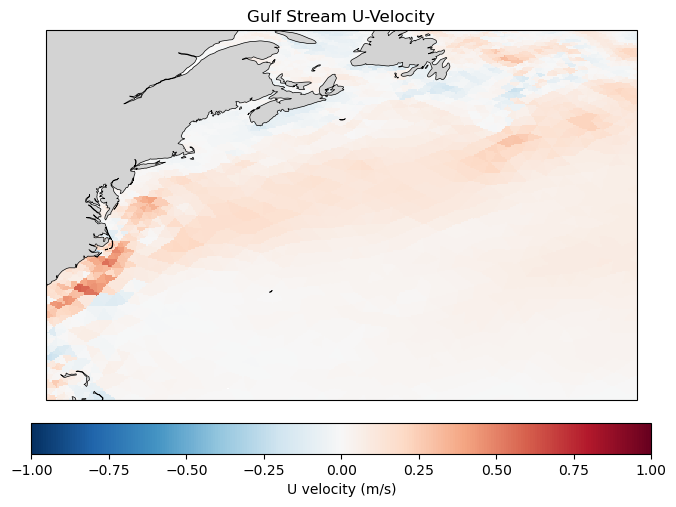

In [102]:
# Gulf Stream region
fig, ax, _ = nr.plot(
    u_surface, lon_elem, lat_elem,
    extent=(-80, -40, 25, 50),
    resolution=0.1,
    title="Gulf Stream U-Velocity",
    colorbar_label="U velocity (m/s)",
    cmap="RdBu_r",
    vmin=-1.0, vmax=1.0,
    land=True, 
)

## 10. Vertical Transects

Use `nr.transect()` to plot vertical cross-sections along a path.

In [103]:
# Get 3D temperature data for transect
temp_3d = temp.temp.isel(time=0).values  # Shape: (nz1, nod2)
depth = temp.nz1.values

print(f"3D temperature shape: {temp_3d.shape}")
print(f"Depth levels: {len(depth)}")

3D temperature shape: (47, 126858)
Depth levels: 47


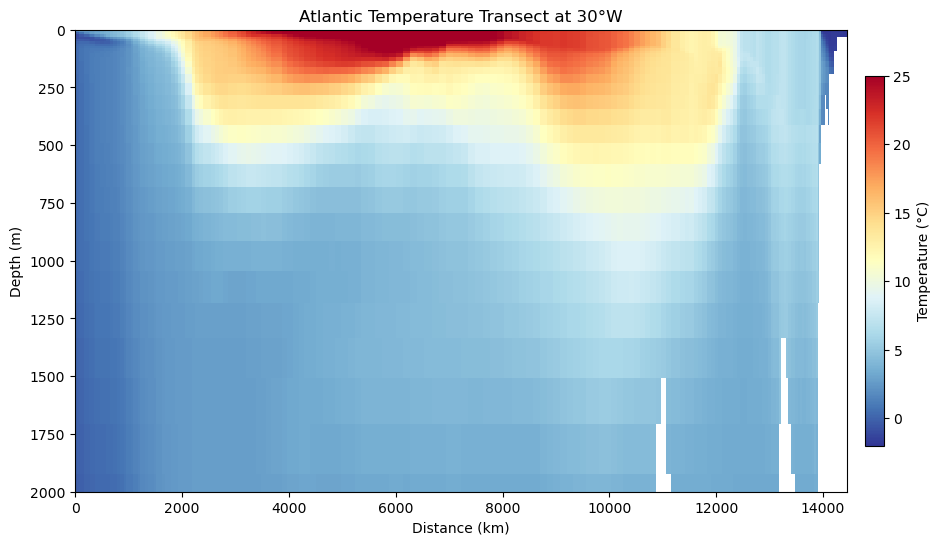

In [106]:
# Atlantic meridional transect at 30°W
fig, ax = nr.transect(
    temp_3d, lon, lat, depth,
    start=(-30, -60),  # South Atlantic
    end=(-30, 70),     # North Atlantic
    n_points=200,
    title="Atlantic Temperature Transect at 30°W",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    depth_lim=(0, 2000),
    vmin=-2, vmax=25
)

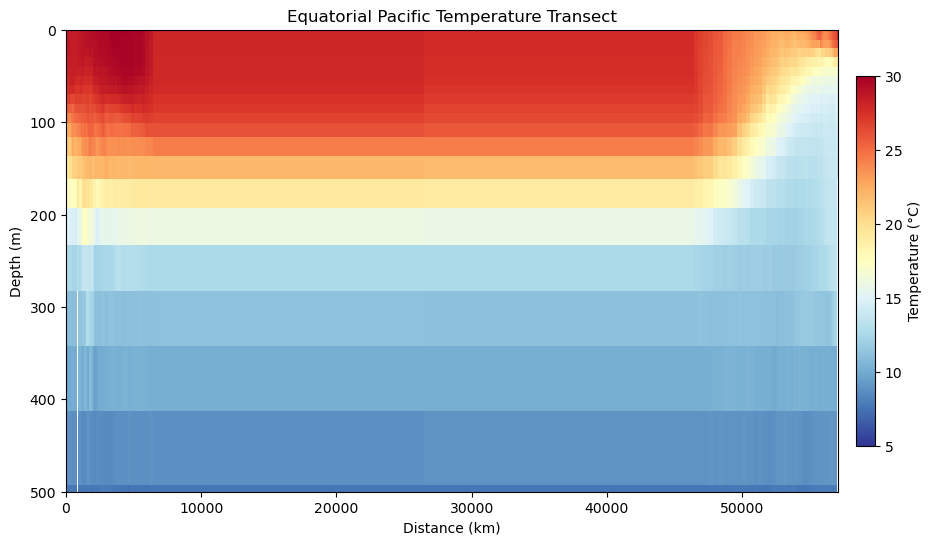

In [109]:
# Pacific zonal transect at equator
fig, ax = nr.transect(
    temp_3d, lon, lat, depth,
    start=(120, 0),    # Western Pacific
    end=(-80, 0),      # Eastern Pacific
    n_points=200,
    title="Equatorial Pacific Temperature Transect",
    colorbar_label="Temperature (°C)",
    cmap="RdYlBu_r",
    depth_lim=(0, 500),
    vmin=5, vmax=30
)

## 11. Cache Management

Nereus automatically caches interpolators for reuse. You can configure the cache behavior.

In [110]:
# Configure cache (optional)
nr.set_cache_options(
    max_memory_items=20  # Keep up to 20 interpolators in memory
)

# The cache is used automatically by nr.plot() when use_cache=True (default)
# This means repeated plots with the same coordinates and resolution are fast

In [112]:
%%time
# First plot (creates interpolator)
fig, ax, _ = nr.plot(temp['temp'][0,0,:], lon, lat, resolution=0.5, title="First plot")
plt.close(fig)

CPU times: user 294 ms, sys: 10.8 ms, total: 305 ms
Wall time: 296 ms


In [113]:
%%time
# Second plot with same settings (uses cached interpolator - much faster!)
fig, ax, _ = nr.plot(temp['temp'][0,0,:], lon, lat, resolution=0.5, title="Second plot (cached)")
plt.close(fig)

CPU times: user 72.9 ms, sys: 6.1 ms, total: 79 ms
Wall time: 69.7 ms


## 12. Plot Customization

Additional options for customizing plots.

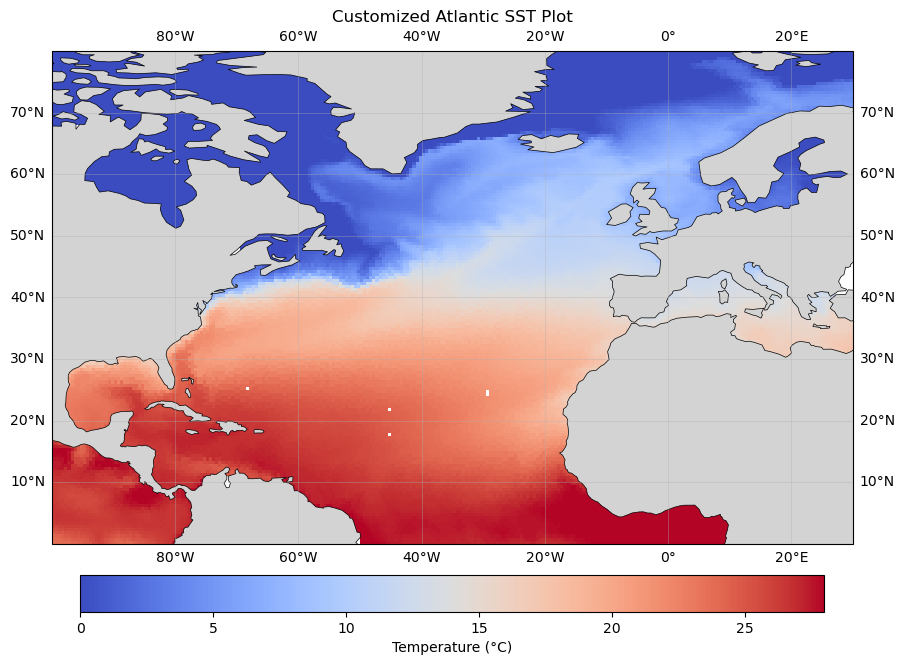

In [114]:
# Full customization example
fig, ax, _ = nr.plot(
    temp['temp'][0,0,:], lon, lat,
    projection="pc",
    extent=(-100, 30, 0, 80),
    resolution=0.5,
    cmap="coolwarm",
    vmin=0, vmax=28,
    coastlines=True,
    land=True,
    gridlines=True,
    colorbar=True,
    colorbar_label="Temperature (°C)",
    title="Customized Atlantic SST Plot",
    figsize=(12, 8)
)

Text(0.5, 0.98, 'SST Comparison')

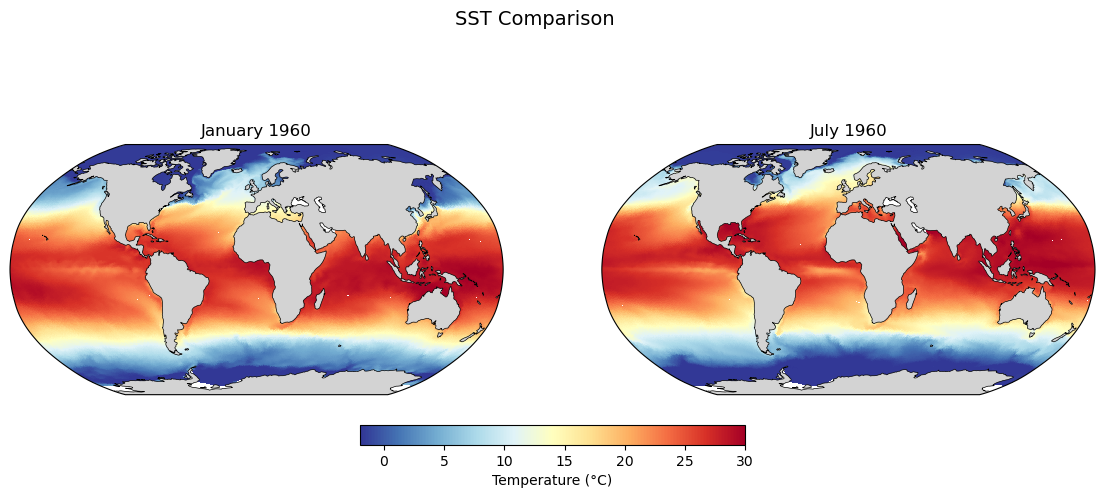

In [120]:
# Multiple panels with shared colorbar
import cartopy.crs as ccrs

fig, axes = plt.subplots(1, 2, figsize=(14, 5),
                         subplot_kw={'projection': ccrs.Robinson()})

# January
fig1, ax1, _ = nr.plot(
    temp.temp.isel(time=0, nz1=0).values, lon, lat,
    ax=axes[0],
    interpolator=interp,
    title="January 1960",
    cmap="RdYlBu_r",
    vmin=-2, vmax=30,
    colorbar=False,
    land=True
)

# July
fig2, ax2, _ = nr.plot(
    temp.temp.isel(time=6, nz1=0).values, lon, lat,
    ax=axes[1],
    interpolator=interp,
    title="July 1960",
    cmap="RdYlBu_r",
    vmin=-2, vmax=30,
    colorbar=False,
    land=True
    
)

# Add shared colorbar
cbar = fig.colorbar(ax2.collections[1], ax=axes, orientation='horizontal',
                    fraction=0.05, pad=0.08, label='Temperature (°C)')

plt.suptitle("SST Comparison", fontsize=14)

## Summary

This notebook demonstrated the main features of `nereus`:

1. **`nr.plot()`** - Plot unstructured data on maps with various projections
2. **`nr.regrid()`** - Regrid data to regular grids for analysis
3. **`nr.RegridInterpolator`** - Create reusable interpolators for batch processing
4. **`nr.transect()`** - Create vertical cross-sections (0 at top for ocean, optionally inverted for atmosphere)
5. **`nr.set_cache_options()`** - Configure interpolator caching
6. **`compute_element_centers()`** - Compute element centers handling dateline crossing

### Projection shortcuts:
- `pc` - PlateCarree
- `rob` - Robinson
- `moll` - Mollweide
- `merc` - Mercator
- `np` - North Polar
- `sp` - South Polar
- `ortho` - Orthographic
- `lcc` - Lambert Conformal

### Default parameters:
- `influence_radius=80_000` (80 km) - increase for coarse meshes
- Colorbar displayed horizontally at bottom of plots
- Transects: depth increases downward (set `invert_depth=False` for atmosphere)